<a href="https://colab.research.google.com/github/cosmo3769/reinforcement_learning/blob/master/CliffWalking_Q_Learning_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Imports

In [1]:
# Check if the notebook is running on colab or not.
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f'Is the notebook using colab environment: {COLAB}')

if COLAB:
    # Install W&B for MLOPs.
    print(f'Installing Weights and Biases')
    !pip install -qq --upgrade wandb
    # Install gymnasium
    print(f'Installing gymnasium')
    !pip install -qq gymnasium

Is the notebook using colab environment: True
Installing Weights and Biases
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
Installing gymnasium
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.7 MB/s eta 0:00:00


In [2]:
# Login to your W&B account.
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import random
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from argparse import Namespace
from tqdm.notebook import tqdm

# Initializing env

In [4]:
env = gym.make('CliffWalking-v0', render_mode="rgb_array")

# Observation Space

In [5]:
print("Observation Space =", env.observation_space)
print("Sample observation =", env.observation_space.sample()) # Get a random observation

Observation Space = Discrete(48)
Sample observation = 18


# Action Space

In [6]:
print("Action Space =", env.action_space)
print("Sample action =", env.action_space.sample()) # Take a random action

Action Space = Discrete(4)
Sample action = 2


# Observing the environment

In [7]:
state, info = env.reset()

In [8]:
print("Initial start state =", state)
print("Transition probability =", info)

Initial start state = 36
Transition probability = {'prob': 1}


# Executing an action

In [9]:
action = env.action_space.sample()
print("Action taken =", action)

new_state, reward, terminated, truncated, info = env.step(action)
print("State (index) reached after taking an action =", new_state)
print("Reward recieved after taking an action =", reward)
print("Is terminated? =", terminated)
print("Is truncated? =", truncated)
print("Transition probability =", info)

Action taken = 0
State (index) reached after taking an action = 24
Reward recieved after taking an action = -1
Is terminated? = False
Is truncated? = False
Transition probability = {'prob': 1.0}


# Initializing Q-table

In [10]:
state_space = env.observation_space.n
print("There are", state_space, "possible states in `CliffWalking-v0` environment.")

action_space = env.action_space.n
print("There are", action_space, "possible actions that we can select to move in `CliffWalking-v0 environment.")

There are 48 possible states in `CliffWalking-v0` environment.
There are 4 possible actions that we can select to move in `CliffWalking-v0 environment.


In [11]:
# Let's create our Qtable of size (state_space, action_space) and initialize each values to 0.
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [12]:
Qtable_cliffwalking = initialize_q_table(state_space, action_space)

In [13]:
Qtable_cliffwalking

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


# Build the agent

In [14]:
class CliffwalkingAgent:
    def __init__(self, args):
        self.args = args
        self.training_error = []

    def get_action(
        self,
        Qtable,
        state,
        epsilon
    ):
        if np.random.random() > epsilon:
            return np.argmax(Qtable[state][:])
        else:
            return env.action_space.sample()

    def update(
        self,
        Qtable,
        state,
        new_state,
        action
    ):
        td_target = reward + self.args.discount_factor * np.max(Qtable[new_state])
        td_error = td_target - Qtable[state][action]
        self.training_error.append(td_error)
        return Qtable[state][action] + self.args.learning_rate * td_error

    def decay_epsilon(
        self,
        episode
    ):
        exp_decay = np.exp(-self.args.decay_rate * episode)
        return self.args.min_epsilon + (self.args.max_epsilon - self.args.min_epsilon) * exp_decay

# Hyperparameters

In [15]:
configs = Namespace(
    # Training parameters
    n_training_episodes = 100000,       # Total number of training episodes
    learning_rate = 0.7,                # Learning rate

    # Evaluation parameters
    n_eval_episodes = 100,              # Total number of test episodes

    # Environment parameters
    env_id = "CliffWalking-v0",         # Environment name
    max_steps = 99,                     # Max steps per episode
    discount_factor = 0.95,             # Discount Factor
    eval_seed = [],                     # Evaluation seed of the environment

    # Exploration parameters
    max_epsilon = 1.0,                  # Exploration probability at start
    min_epsilon = 0.05,                 # Minimum exploration probability (start exploiting)
    decay_rate = 0.0005,                # Exponential decay rate for exploration prob
)

# Training Loop

In [16]:
agent = CliffwalkingAgent(configs)

In [17]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=configs.n_training_episodes)

def train(n_training_episodes, max_steps, Qtable):
    """
    Train the agent for ``n_training_episodes`` episodes.
    :param env: The training environment
    :param max_steps: Maximum number of steps per episode
    :param Q: The Q-table
    """
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = agent.decay_epsilon(episode)
        # Reset the environment
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        # repeat
        for step in range(max_steps):
            # Use (epsilon greedy policy) to choose the action At
            action = agent.get_action(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the newstate(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = agent.update(Qtable, state, new_state, action)

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

            # Our next state is the new state
            state = new_state

    return Qtable

In [18]:
Qtable_cliffwalking = train(configs.n_training_episodes, configs.max_steps, Qtable_cliffwalking)

  0%|          | 0/100000 [00:00<?, ?it/s]

# Updated Q-values

In [19]:
Qtable_cliffwalking

array([[-10.7341754 , -10.24650042, -10.24650042, -10.7341754 ],
       [-10.24650042,  -9.73315833,  -9.73315833, -10.7341754 ],
       [ -9.73315833,  -9.19279825,  -9.19279825, -10.24650042],
       [ -9.19279825,  -8.62399815,  -8.62399815,  -9.73315833],
       [ -8.62399815,  -8.02526122,  -8.02526122,  -9.19279825],
       [ -8.02526122,  -7.39501181,  -7.39501181,  -8.62399815],
       [ -7.39501181,  -6.73159137,  -6.73159137,  -8.02526122],
       [ -6.73159137,  -6.03325408,  -6.03325408,  -7.39501181],
       [ -6.03325408,  -5.29816219,  -5.29816219,  -6.73159137],
       [ -5.29816219,  -4.52438125,  -4.52438125,  -6.03325408],
       [ -4.52438125,  -3.709875  ,  -3.709875  ,  -5.29816219],
       [ -3.709875  ,  -3.709875  ,  -2.8525    ,  -4.52438125],
       [-10.7341754 ,  -9.73315833,  -9.73315833, -10.24650042],
       [-10.24650042,  -9.19279825,  -9.19279825, -10.24650042],
       [ -9.73315833,  -8.62399815,  -8.62399815,  -9.73315833],
       [ -9.19279825,  -8

# Evaluate trained Agent

In [20]:
def evaluate_agent(env, max_steps, n_eval_episodes, Qtable, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for cliffwalking)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state, info = env.reset(seed=seed[episode])
    else:
      state, info = env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Qtable[state][:])
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [21]:
mean_reward, std_reward = evaluate_agent(env, configs.max_steps, configs.n_eval_episodes, Qtable_cliffwalking, configs.eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=-13.00 +/- 0.00


# Visualization chart

In [22]:
rolling_length = 500

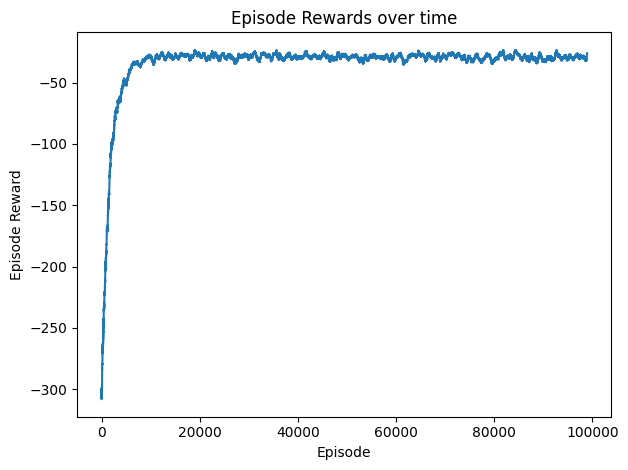

In [23]:
fig0, ax0 = plt.subplots()

# Plot Episode rewards
ax0.set_title("Episode Rewards over time")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
ax0.plot(reward_moving_average, label='Rolling Average')
ax0.set_xlabel("Episode")
ax0.set_ylabel("Episode Reward")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

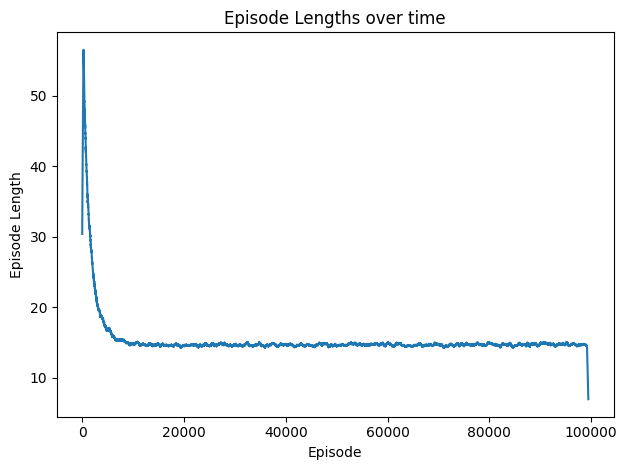

In [24]:
fig1, ax1 = plt.subplots()

# Plot Episode lengths
ax1.set_title("Episode Lengths over time")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
ax1.plot(length_moving_average, label='Rolling Average')
ax1.set_xlabel("Episode")
ax1.set_ylabel("Episode Length")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

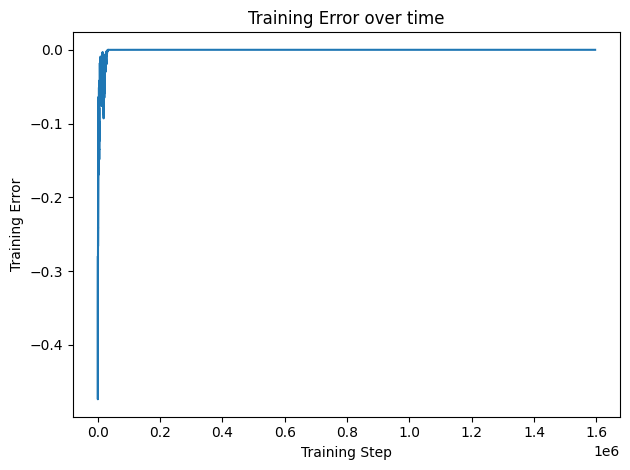

In [25]:
fig2, ax2 = plt.subplots()

# Plot Training Error
ax2.set_title("Training Error over time")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
ax2.plot(training_error_moving_average, label='Rolling Average')
ax2.set_xlabel("Training Step")
ax2.set_ylabel("Training Error")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Record Video of Optimal Policy

In [26]:
def record_video(env, Qtable, fps=1):
  """
  Generate a video of the optimal policy path
  :param env
  :param Qtable: Qtable of our agent
  :param fps: how many frame per seconds (with CliffWalking-v0 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Use (greedy policy) to take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  frames = np.transpose(np.array(images, dtype=np.uint8), (0, 3, 1, 2)) # We reshaped frames to log to wandb
  return frames

# Log visualization chart and video to wandb

In [27]:
# Initialize wandb run
wandb.init(
    entity='cosmo3769',
    project='Q-Learning',
    config=vars(configs),
    name=f'{configs.env_id}'
)

# Log visualization chart
wandb.log({'Episode Rewards over time': fig0})
wandb.log({'Episode Lengths over time': fig1})
wandb.log({'Training Error over time': fig2})

# Log optimal policy path
optimal_policy_recorded_frames = record_video(env, Qtable_cliffwalking, fps=1)
wandb.log({"optimal policy path": wandb.Video(optimal_policy_recorded_frames, fps=1)})

# Finish wandb run
wandb.finish()

wandb: Currently logged in as: cosmo3769. Use `wandb login --relogin` to force relogin
